In [16]:
# --- 1b. Imports and Initial Setup ---
import os
import gc
import numpy as np
import pandas as pd
import zipfile
from typing import Tuple, Dict, List
import random
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Import PyTorch Geometric
import torch_geometric.data as pyg_data
from torch_geometric.nn import Node2Vec

from sklearn.metrics import average_precision_score, roc_auc_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

# --- Environment and Threading Settings ---
os.environ.setdefault("OMP_NUM_THREADS", "4")
os.environ.setdefault("MKL_NUM_THREADS", "4")
torch.set_num_threads(4)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# --- Memory Optimization ---
def clean_memory():
    """Forces Python GC and clears PyTorch CUDA cache."""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

clean_memory()
print("Initial memory cleanup complete.")

# --- Set Random Seeds for Reproducibility ---
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# --- Define Column Names ---
SRC_COL = 'Src IP'
DST_COL = 'Dst IP'
LABEL_COL = 'target'
ZIP_DATA_PATH = "data.zip"

print("Setup complete. This notebook will process the raw, non-aggregated graph.")

Using device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
Initial memory cleanup complete.
Setup complete. This notebook will process the raw, non-aggregated graph.


In [17]:
# --- 2. Raw Data Loading Function ---

def load_raw_data_sequential(zip_path: str, file_name: str) -> pd.DataFrame:
    """Loads a single raw CSV with optimized data types."""
    print(f"--- Loading raw data from {file_name} ---")
    
    # Use minimal dtypes. IPs are objects, label is a small integer.
    dtype_mapping = {LABEL_COL: 'int8'}
    
    with zipfile.ZipFile(zip_path, 'r') as z:
        with z.open(file_name) as f:
            df = pd.read_csv(f, usecols=[SRC_COL, DST_COL, LABEL_COL], dtype=dtype_mapping)
    
    print(f"Loaded raw data, shape={df.shape}. Dtypes optimized.")
    return df

# --- Execution ---
print("=== Starting Sequential Raw Data Load ===")
train_df = load_raw_data_sequential(ZIP_DATA_PATH, 'train.csv')
test_df = load_raw_data_sequential(ZIP_DATA_PATH, 'test.csv')

clean_memory()
print("\nRaw data loading complete.")

=== Starting Sequential Raw Data Load ===
--- Loading raw data from train.csv ---
Loaded raw data, shape=(25901651, 3). Dtypes optimized.
--- Loading raw data from test.csv ---
Loaded raw data, shape=(6475413, 3). Dtypes optimized.

Raw data loading complete.


In [18]:
# --- 3. Graph Prep and Training with PyTorch Geometric ---

def build_pyg_graph_and_train(train_df: pd.DataFrame, test_df: pd.DataFrame, src_col: str, dst_col: str, **kwargs) -> Tuple[Dict, Dict]:
    """
    Builds a PyG Data object from the *full* (train + test) graph structure,
    trains Node2Vec, and returns mappings and embeddings.
    """
    print("--- Preparing full graph (train + test) for PyTorch Geometric ---")

    # 1. Combine train and test data to get the full graph structure
    # We only need the edge columns, not the labels from the test set
    print("   Combining train/test edge lists...")
    train_edges = train_df[[src_col, dst_col]]
    test_edges = test_df[[src_col, dst_col]]
    full_df = pd.concat([train_edges, test_edges], ignore_index=True)

    # 2. Clean the full data to prevent errors
    full_df.dropna(subset=[src_col, dst_col], inplace=True)

    # 3. Create IP to integer index mapping from the FULL graph
    print("   Generating full node mapping...")
    all_ips = pd.unique(pd.concat([full_df[src_col], full_df[dst_col]]))
    ip2idx = {ip: i for i, ip in enumerate(all_ips)}
    num_nodes = len(all_ips)
    print(f"Found {num_nodes} unique nodes in the full graph.")

    # 4. Create the edge_index tensor for PyG from the FULL graph
    print("   Creating full edge_index tensor...")
    src_idx = torch.tensor(full_df[src_col].map(ip2idx).values, dtype=torch.long)
    dst_idx = torch.tensor(full_df[dst_col].map(ip2idx).values, dtype=torch.long)
    edge_index = torch.stack([src_idx, dst_idx], dim=0)

    # 5. Clean up large DataFrame before training
    del full_df, train_edges, test_edges, src_idx, dst_idx
    clean_memory()
    
    # 4. Create a PyG Data object
    data = pyg_data.Data(edge_index=edge_index, num_nodes=num_nodes).to(device)

    # 5. Initialize and train the Node2Vec model
    print("\n--- Training Node2Vec with PyTorch Geometric ---")
    model = Node2Vec(
        data.edge_index,
        embedding_dim=kwargs.get('embedding_dim', 32),
        walk_length=kwargs.get('walk_length', 10), #10
        context_size=kwargs.get('context_size', 10),
        walks_per_node=kwargs.get('walks_per_node', 8), #8
        p=kwargs.get('p', 1.0),
        q=kwargs.get('q', 0.7), #0.7
        num_negative_samples=3, # 3
        sparse=True,
    ).to(device)

    # The loader and optimizer are specific to the Node2Vec training
    loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
    optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

    def train_epoch():
        model.train()
        total_loss = 0
        for pos_rw, neg_rw in loader:
            optimizer.zero_grad()
            loss = model.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(loader)

    for epoch in range(1, 51): # 50 epochs is usually enough for Node2Vec
        loss = train_epoch()
        if epoch % 5 == 0:
            print(f"Node2Vec Epoch: {epoch:02d}, Loss: {loss:.4f}")

    # 6. Extract embeddings and convert to the dictionary format
    # We move the final embeddings to the CPU for the next steps
    final_embeddings_tensor = model.embedding.weight.data.cpu()
    embeddings = {i: final_embeddings_tensor[i].numpy() for i in range(num_nodes)}
    
    print(f"\nLearned embeddings for {len(embeddings)} nodes.")
    return ip2idx, embeddings

# --- Execution ---
EMBEDDING_DIM = 32
ip2idx, embeddings = build_pyg_graph_and_train(
    train_df, test_df, SRC_COL, DST_COL, embedding_dim=EMBEDDING_DIM
)

clean_memory()
print("PyTorch Geometric training complete.")

--- Preparing full graph (train + test) for PyTorch Geometric ---
   Combining train/test edge lists...
   Generating full node mapping...
Found 107583 unique nodes in the full graph.
   Creating full edge_index tensor...

--- Training Node2Vec with PyTorch Geometric ---
Node2Vec Epoch: 05, Loss: 1.2459
Node2Vec Epoch: 10, Loss: 0.9275
Node2Vec Epoch: 15, Loss: 0.8689
Node2Vec Epoch: 20, Loss: 0.8600
Node2Vec Epoch: 25, Loss: 0.8526
Node2Vec Epoch: 30, Loss: 0.8478
Node2Vec Epoch: 35, Loss: 0.8459
Node2Vec Epoch: 40, Loss: 0.8447
Node2Vec Epoch: 45, Loss: 0.8427
Node2Vec Epoch: 50, Loss: 0.8426

Learned embeddings for 107583 nodes.
PyTorch Geometric training complete.


In [19]:
# --- 4. Custom PyTorch Dataset for Edge Events ---

class EdgeEventDataset(Dataset):
    """
    PyTorch Dataset that generates features on-the-fly for each edge event.
    This is memory-efficient as it avoids storing the full feature matrix.
    """
    def __init__(self, df: pd.DataFrame, ip2idx: Dict, embeddings: Dict, embedding_dim: int):
        self.df = df.reset_index(drop=True)
        self.ip2idx = ip2idx
        self.embeddings = embeddings
        self.src_ips = df[SRC_COL].values
        self.dst_ips = df[DST_COL].values
        self.labels = df[LABEL_COL].values
        
        # A zero vector for IPs not found in the embedding dictionary
        self.zero_embedding = np.zeros(embedding_dim, dtype=np.float32)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        # Get IPs and label for the given index
        src_ip = self.src_ips[idx]
        dst_ip = self.dst_ips[idx]
        label = self.labels[idx]

        # Get integer indices for IPs
        src_node_idx = self.ip2idx.get(src_ip)
        dst_node_idx = self.ip2idx.get(dst_ip)
        
        # Look up embeddings, using the zero vector for unseen nodes
        src_emb = self.embeddings.get(src_node_idx, self.zero_embedding)
        dst_emb = self.embeddings.get(dst_node_idx, self.zero_embedding)
        
        # Concatenate embeddings to create the feature vector
        features = np.concatenate([src_emb, dst_emb])

        # Use Hadamard (element-wise) product to create the feature vector
        #features = src_emb * dst_emb # This is now shape (32,)
        
        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# --- Verifying Test Set Nodes ---
# Since we trained on the full graph, all test IPs should be in ip2idx.
print("\n=== Verifying Test Set Nodes ===")
unseen_nodes_count = 0
all_test_ips = pd.unique(pd.concat([test_df[SRC_COL], test_df[DST_COL]]))
for ip in all_test_ips:
    if ip not in ip2idx:
        # This should not happen, but good to check for malformed data
        unseen_nodes_count += 1

if unseen_nodes_count > 0:
    print(f"Warning: Found {unseen_nodes_count} test IPs still not in the mapping. This might indicate malformed data.")
else:
    print("Verification successful: All test set IPs are present in the embedding map.")

# --- Create Datasets and DataLoaders ---
print("\n=== Creating Datasets and DataLoaders ===")
train_dataset = EdgeEventDataset(train_df, ip2idx, embeddings, EMBEDDING_DIM)
test_dataset = EdgeEventDataset(test_df, ip2idx, embeddings, EMBEDDING_DIM)

# The DataLoader will handle batching, shuffling, and multi-process data loading
train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=4096, shuffle=False, num_workers=4, pin_memory=True)

# CRITICAL CLEANUP: We no longer need the raw DataFrames in memory
del train_df, test_df, embeddings, ip2idx
clean_memory()
print("Raw DataFrames and embeddings dictionary deleted. Ready for training.")


=== Verifying Test Set Nodes ===
Verification successful: All test set IPs are present in the embedding map.

=== Creating Datasets and DataLoaders ===
Raw DataFrames and embeddings dictionary deleted. Ready for training.


Calculating class weights (approximate)...
Positive class weight: 9.42

--- Starting MLP Training ---


/tmp/ipykernel_11199/2896254275.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weight = torch.tensor(pos_weight, dtype=torch.float32).to(device)


Epoch 01 | Loss: 0.0007 | Time: 75.61s
Epoch 02 | Loss: 0.0001 | Time: 76.91s
Epoch 03 | Loss: 0.0001 | Time: 76.42s
Epoch 04 | Loss: 0.0001 | Time: 84.48s
Epoch 05 | Loss: 0.0001 | Time: 77.24s

Test PR-AUC: 0.9999
Test ROC-AUC: 0.9999

--- Model Performance on the Inductive Test Set ---

Per-Class Metrics:
| Metric       | Benign (0) | Attack (1) |
|--------------|------------|------------|
| Precision    | 1.0000     | 1.0000     |
| Recall       | 1.0000     | 0.9998     |
| F1-score     | 1.0000     | 0.9999     |

Macro-Average Metrics:
| Metric       | Score      |
|--------------|------------|
| MA Precision | 1.0000     |
| MA Recall    | 0.9999     |
| MA F1-score  | 0.9999     |


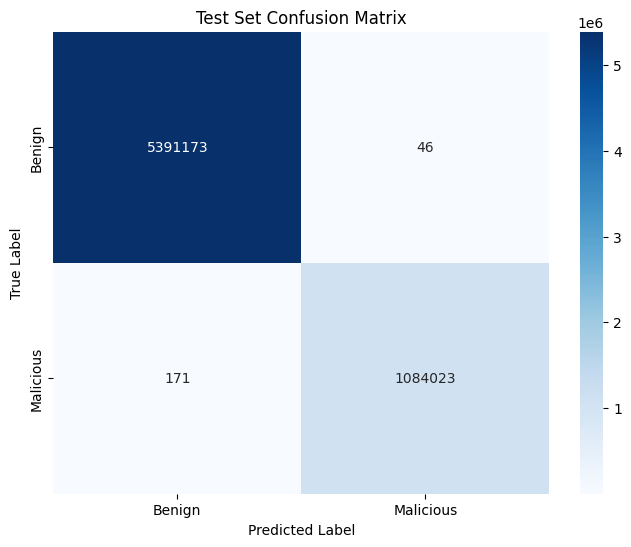


Confusion Matrix Details:
  True Negatives:  5391173
  False Positives: 46
  False Negatives: 171
  True Positives:  1084023

=== Final Results Summary ===
Test PR-AUC: 0.9999
Test ROC-AUC: 0.9999
Attack F1-score: 0.9999
Macro F1-score: 0.9999
Model parameters: 57922

Final cleanup complete.


In [20]:
# --- 5. MLP Classifier and Training Loop ---

class MLPEdgeClassifier(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: List[int] = [256, 128, 64]):
        super().__init__()
        layers = []
        in_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))
            in_dim = hidden_dim
        layers.append(nn.Linear(in_dim, 2))
        self.mlp = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.mlp(x)

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    return cm

def train_and_evaluate_mlp(model, train_loader, test_loader, epochs=5, lr=1e-3):
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    
    # Calculate class weights from the training dataset
    # This is an approximation; for huge datasets, you might pre-calculate or use a subset
    print("Calculating class weights (approximate)...")
    num_neg = sum(1 for _, y in train_loader.dataset if y == 0)
    num_pos = sum(1 for _, y in train_loader.dataset if y == 1)
    pos_weight = torch.tensor(num_neg / max(num_pos, 1), dtype=torch.float32).to(device)
    #pos_weight_VAL= 9.5

    pos_weight = torch.tensor(pos_weight, dtype=torch.float32).to(device)
    loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([1.0, pos_weight], device=device))
    print(f"Positive class weight: {pos_weight.item():.2f}")

    print("\n--- Starting MLP Training ---")
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        start_time = time.time()
        
        for i, (batch_X, batch_y) in enumerate(train_loader):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            logits = model(batch_X)
            loss = loss_fn(logits, batch_y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch:02d} | Loss: {avg_loss:.4f} | Time: {epoch_time:.2f}s")

    # --- Evaluation ---
    model.eval()
    all_probs, all_preds, all_true = [], [], []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            
            logits = model(batch_X)
            probs = torch.softmax(logits, 1)[:, 1].cpu().numpy()
            preds = logits.argmax(dim=1).cpu().numpy()
            
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_true.extend(batch_y.numpy())
    
    pr_auc = average_precision_score(all_true, all_probs)
    roc_auc = roc_auc_score(all_true, all_probs)
    
    print(f"\nTest PR-AUC: {pr_auc:.4f}")
    print(f"Test ROC-AUC: {roc_auc:.4f}")

    # === NEW METRICS BLOCK ===
    print("\n--- Model Performance on the Inductive Test Set ---")
    
    # Generate the classification report as a dictionary
    # We specify labels=[0, 1] to ensure '0' (Benign) and '1' (Attack) are always present
    report_dict = classification_report(
        all_true, 
        all_preds, 
        labels=[0, 1], 
        target_names=['Benign (0)', 'Attack (1)'], 
        output_dict=True,
        zero_division=0
    )

    # Extract reports for easier access
    benign_report = report_dict['Benign (0)']
    attack_report = report_dict['Attack (1)']
    macro_report = report_dict['macro avg']

    # Print the Per-Class Metrics Table
    print("\nPer-Class Metrics:")
    print(f"| {'Metric':<12} | {'Benign (0)':<10} | {'Attack (1)':<10} |")
    print(f"|{'-'*14}|{'-'*12}|{'-'*12}|")
    print(f"| {'Precision':<12} | {benign_report['precision']:<10.4f} | {attack_report['precision']:<10.4f} |")
    print(f"| {'Recall':<12} | {benign_report['recall']:<10.4f} | {attack_report['recall']:<10.4f} |")
    print(f"| {'F1-score':<12} | {benign_report['f1-score']:<10.4f} | {attack_report['f1-score']:<10.4f} |")

    # Print the Macro-Average Metrics Table
    print("\nMacro-Average Metrics:")
    print(f"| {'Metric':<12} | {'Score':<10} |")
    print(f"|{'-'*14}|{'-'*12}|")
    print(f"| {'MA Precision':<12} | {macro_report['precision']:<10.4f} |")
    print(f"| {'MA Recall':<12} | {macro_report['recall']:<10.4f} |")
    print(f"| {'MA F1-score':<12} | {macro_report['f1-score']:<10.4f} |")
    # === END OF NEW METRICS BLOCK ===
    
    cm = plot_confusion_matrix(all_true, all_preds, title="Test Set Confusion Matrix")
    tn, fp, fn, tp = cm.ravel()
    print(f"\nConfusion Matrix Details:")
    print(f"  True Negatives:  {tn}\n  False Positives: {fp}")
    print(f"  False Negatives: {fn}\n  True Positives:  {tp}")
    
    # Update the return dictionary with all metrics
    results_dict = {
        'pr_auc': pr_auc,
        'roc_auc': roc_auc,
        'precision_benign': benign_report['precision'],
        'recall_benign': benign_report['recall'],
        'f1_benign': benign_report['f1-score'],
        'precision_attack': attack_report['precision'],
        'recall_attack': attack_report['recall'],
        'f1_attack': attack_report['f1-score'],
        'ma_precision': macro_report['precision'],
        'ma_recall': macro_report['recall'],
        'ma_f1': macro_report['f1-score']
    }
    return results_dict

# --- Execution ---
input_dim = EMBEDDING_DIM * 2  # src_emb + dst_emb
mlp_model = MLPEdgeClassifier(input_dim, hidden_dims=[256, 128, 64])
results = train_and_evaluate_mlp(mlp_model, train_loader, test_loader, epochs=5) # Using fewer epochs due to longer time

print("\n=== Final Results Summary ===")
print(f"Test PR-AUC: {results['pr_auc']:.4f}")
print(f"Test ROC-AUC: {results['roc_auc']:.4f}")
print(f"Attack F1-score: {results['f1_attack']:.4f}")
print(f"Macro F1-score: {results['ma_f1']:.4f}")
print(f"Model parameters: {sum(p.numel() for p in mlp_model.parameters())}")

del mlp_model, train_loader, test_loader
clean_memory()
print("\nFinal cleanup complete.")